In [1]:
import pandas as pd

# Load the CSV file
# file_path = 'subnet_cost.csv'
# data = pd.read_csv(file_path)

data = pd.read_json('cost_log.json')

#rename columns
data.columns = ['datetime', 'cost']

# Display the first few rows of the dataframe to understand its structure
data.head(20)

,datetime,cost
0,2024-02-20 07:27:10.547150,758.513900
1,2024-02-20 07:32:15.553964,757.855217
2,2024-02-20 07:37:20.774481,757.196533
3,2024-02-20 07:42:25.890549,756.511502
4,2024-02-20 07:47:31.251312,755.879165
5,2024-02-20 07:52:36.450167,755.194134
6,2024-02-20 07:57:41.730610,754.535450
7,2024-02-20 08:02:46.626538,753.929461
8,2024-02-20 08:07:52.133176,753.218083
9,2024-02-20 08:12:57.218559,752.638441


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  194 non-null    object 
 1   cost      194 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.5+ KB


In [3]:
from datetime import datetime

# Convert the year, month, day, hour, minute, and second columns into a single datetime column
# data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour', 'minute', 'second']])
data['datetime'] = pd.to_datetime(data['datetime'])

# Ensure the cost column is in a numeric format
data['cost'] = pd.to_numeric(data['cost'], errors='coerce')

# Sort the data by datetime just in case it's not in order
data = data.sort_values(by='datetime')

# Drop any rows with NaN values in the cost column, as they cannot be used for prediction
data = data.dropna(subset=['cost'])

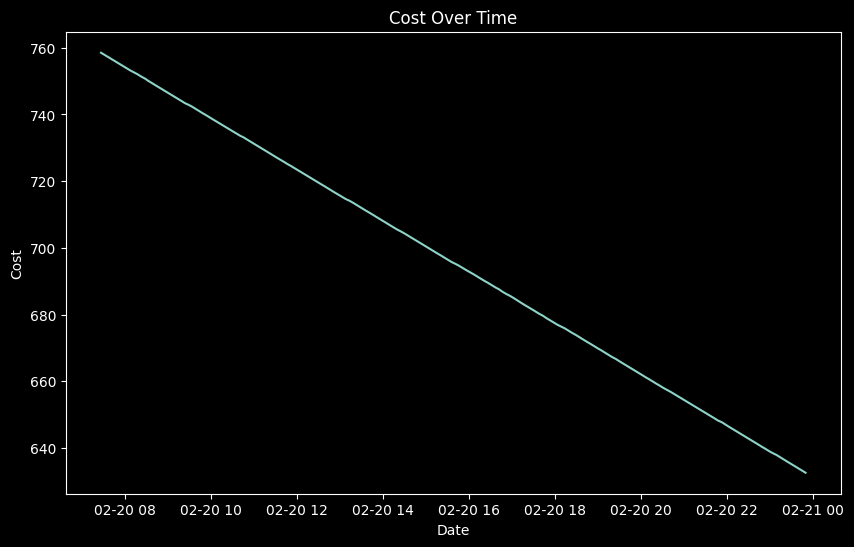

In [4]:
# visual timeplot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data['datetime'], data['cost'])
plt.xlabel('Date')
plt.ylabel('Cost')
plt.title('Cost Over Time')
plt.show()


In [5]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data for linear regression
# Convert datetime to a numeric format by calculating the number of seconds from the first timestamp
data['seconds_from_start'] = (data['datetime'] - data['datetime'].min()).dt.total_seconds()

# Define the independent variable (X) and the dependent variable (y)
X = data[['seconds_from_start']]
y = data['cost']

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict when the cost will drop below 300 and 200 using the model
# First, we find the seconds from the start to these costs and then convert these back to dates

def predict_date_for_cost(target_cost):
    seconds_from_start_to_target_cost = (target_cost - model.intercept_) / model.coef_[0]
    target_date = data['datetime'].min() + pd.to_timedelta(seconds_from_start_to_target_cost, unit='s')
    return target_date

date_below_363 = predict_date_for_cost(363)
date_below_300 = predict_date_for_cost(300)
date_below_200 = predict_date_for_cost(200)

print(f'Price below 363 date: {date_below_363}')
print(f'Price below 300 date: {date_below_300}')
print(f'Price below 200 date: {date_below_200}')

Price below 363 date: 2024-02-22 10:55:07.652614850
Price below 300 date: 2024-02-22 19:07:02.018825897
Price below 200 date: 2024-02-23 08:07:50.219160893


/Users/tonyle/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


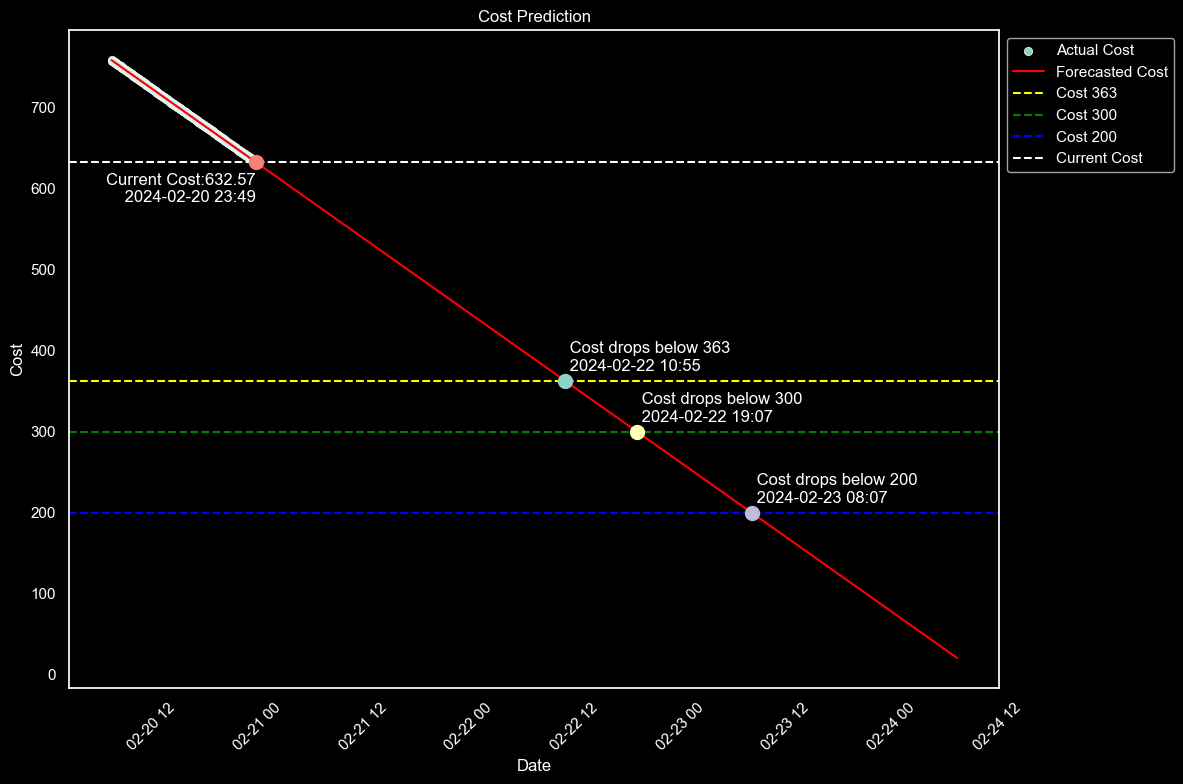

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

# Plotting the data along with the regression line and the points where cost drops below 300 and 200
# set black background with no grid
plt.style.use('dark_background')
# plt.figure(figsize=(12, 8), dpi=100)
# sns.scatterplot(x='datetime', y='cost', data=data, label='Actual Cost')

# Generate dates for predictions (from start to a bit beyond our last prediction) for plotting the regression line
prediction_dates = pd.date_range(start=data['datetime'].min(), end=date_below_200 + pd.Timedelta(days=1))
prediction_seconds_from_start = (prediction_dates - data['datetime'].min()).total_seconds()
prediction_seconds_from_start = prediction_seconds_from_start.to_numpy().reshape(-1, 1)
prediction_costs = model.predict(prediction_seconds_from_start)

# Now, let's plot again with the correction
plt.figure(figsize=(12, 8),dpi=100)
sns.scatterplot(x='datetime', y='cost', data=data, label='Actual Cost')
sns.lineplot(x=prediction_dates, y=prediction_costs, color='red', label='Forecasted Cost')
plt.axhline(y=363, color='yellow', linestyle='--', label='Cost 363')
plt.axhline(y=300, color='green', linestyle='--', label='Cost 300')
plt.axhline(y=200, color='blue', linestyle='--', label='Cost 200')
#current price
plt.axhline(y=data['cost'].iloc[-1], color='white', linestyle='--', label='Current Cost')

current_cost = (data['cost'].iloc[-1]).round(2)

# Highlight the predicted dates for cost dropping below 300 and 200 and 363
for label, date, cost in [('Cost drops below 363', date_below_363, 363),
                          ('Cost drops below 300', date_below_300, 300),
                          ('Cost drops below 200', date_below_200, 200),
                          ]:
    dx, dy = 0, 0.1  # 0 in x direction, 5 points down in y direction
    offset = transforms.ScaledTranslation(dx, dy, plt.gcf().dpi_scale_trans)
    text_transform = plt.gca().transData + offset
    plt.plot(date, cost, 'o', markersize=10)
    plt.text(date, cost, f' {label}\n {date.strftime("%Y-%m-%d %H:%M")}', ha='left', transform=text_transform)

current_label = f'Current Cost:{current_cost}'
current_cost = (data['cost'].iloc[-1]).round(2)
current_date = data['datetime'].iloc[-1]

dx, dy = 0, -0.4  # 0 in x direction, 5 points down in y direction
offset = transforms.ScaledTranslation(dx, dy, plt.gcf().dpi_scale_trans)
text_transform = plt.gca().transData + offset

plt.plot(current_date, current_cost, 'o', markersize=10)
plt.text(current_date, current_cost, f'{current_label}\n {current_date.strftime("%Y-%m-%d %H:%M")}', ha='right', transform=text_transform)

plt.xlabel('Date')
plt.ylabel('Cost')
plt.title('Cost Prediction')
plt.xticks(rotation=45)
# legend outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.grid(False)
